Reinforcement Learning for the Tower of Hanoi
========================

The purpose of this notebook is to be a self-contained explanation of the RL algorithms used in [my GitHub repo](https://github.com/RojerGS/AIML/tree/master/HanoiRL) where I try to solve the Tower of Hanoi.

I will try to be as clear as possible in everything I do, as I will also be taking parts of this notebook (as I write them) and publish them in my [maths and programming blog](https://mathspp.blogspot.com).

Contents of this notebook
---------------------------
 * [The problem](#theproblem)
   - [Encoding the Tower of Hanoi as a markov decision process](#encoding)
   - [Visualizing a game session](#visualization)
 * [Algorithms](#algorithms)
   - [Value iteration](#value_iteration)
   - [Policy iteration](#policy_iteration)
   - [Q-learning](#q_learning)
   - [Double Q-learning](#doubleq_learning)

<a id="theproblem"></a>
The problem
------------

The Tower of Hanoi is a puzzle in the form of a simple toy:

![A Tower of Hanoi toy](https://4.bp.blogspot.com/-RQ2qBzhT4uQ/W7OoofQs0QI/AAAAAAAABDc/Dw5qg_55sGYXEFZ9bIzhUj6TMtVipAvSQCLcBGAs/s1600/frame08.png "Tower of Hanoi")

composed of three poles and a set of different-sized disks (4 in the image above). The disks start all in the left pole, with the biggest disk on the bottom, all the way up to the smallest disk on top. The goal of the puzzle is to move *all* disks to a different pole than the starting one by moving one disk at a time. There is only one simple restriction: a disk can never be on top of a smaller disk!

<a id="encoding"></a>
### Encoding the Tower of Hanoi as a Markov decision process

The first thing to do is to encode the puzzle of the Tower of Hanoi as a Markov decision process. Recall that an [mdp](https://mathspp.blogspot.com/2018/09/markov-decision-processes-basics.html) needs five ingredients to be well-defined, a quintuple $(S, A, P_a, R_a, \gamma)$ with the states, the actions, the transition probabilities, the rewards and the discount factor $\gamma$. The discount factor will be left undefined for now and we will fiddle with it when we implement the different algorithms.

For this explanation assume the number of disks $N$ is fixed. We will define $3^N + 1$ states: $3^N$ are all the ways in which the disks can be distributed legally among the three poles. The $+1$ is for the terminal state we want to reach when the algorithm thinks the puzzle has been completed.

For the regular game states we will use a list of three lists, where each sublist will have the numbers corresponding to the disks in that pole; for example, the list

```
[
[],
[3,2,1],
[4]
]
```

corresponds to the setting of the above image. Notice that bigger numbers correspond to bigger disks and that the bottom of the pole corresponds to the beginning of the list, hence the list above can be further identified with the image above if we rotate the image $90^\circ$ clockwise; the terminal state will be represented by a constanst.

We can thus define the following `define_states` function:

In [2]:
FINAL_STATE = "DONE"    # special state for when the Hanoi Tower was solved

def define_states(n):
    """Recursively define all the possible states of an n-disk Hanoi tower"""
    def aux(n):
        if n == 1:
            return [
                    [[1],[],[]],
                    [[],[1],[]],
                    [[],[],[1]]
                    ]
        else:
            partial = aux(n-1)
            final = []
            for state in partial:
                a, b, c = state
                final.append([[n]+a, b, c])
                final.append([a, [n]+b, c])
                final.append([a, b, [n]+c])
            return final

    return [FINAL_STATE] + aux(n)

After defining the states we now define the actions. We will define $7$ actions: $6$ of them will be the states corresponding to moving disks from one of the poles to any of the other two poles; those will be written as 2-character strings. The first character of the string represents the pole from which we removed and the second character represents the pole in which we want to insert.

The seventh action is for when the algorithm thinks it has completed the puzzle and hence "claims" the puzzle has been finished. For this action we use another constant.

In [3]:
COMPLETED = "COMPLETED" # special action when the MDP thinks we are done
actions = [COMPLETED, "LC", "LR", "CL", "CR", "RL", "RC"]

After having defined states and actions we are now in position to define transition probabilities and rewards. We will assume all actions are available in all game states (_except_ for the terminal state where no action is available) but the restrictions imposed by the rules will be reflected in the transitions.

Whenever a move is illegal (goes against the rules), whenever the move tries to remove a disk from an empty pole or the algorithm claims the puzzle is complete but isn't, we incurr in a penalty and we transition to the exact same state.

Whenever the action represents a move and is legal, the state transition occurs as per the puzzle rules and there is no reward (i.e. the reward is $0$).

Whenever we claim the puzzle is complete from one of the two final positions and thus enter the terminal state, we get a positive reward.

This information is all encoded in the function `transition` which also makes use of the helper function `game_is_done`, used to check if the puzzle has indeed been done.

In [4]:
from copy import deepcopy

def game_is_done(state):
    """Return if the Hanoi Tower was solved;
        Assume we always start with all disks on the left"""
    return (len(state[0]) == len(state[1]) == 0 and \
                sorted(state[2], reverse=True) == state[2]) or \
            (len(state[0]) == len(state[2]) == 0 and \
                sorted(state[1], reverse=True) == state[1])

def transition(state, action):
    """Given a <state> and an <action>, return the new state
        and the reward we got.
    The actions are of the form L|C|R + L|C|R,
        where the first character says from where we remove (Left,Centre,Right)
        the second character says where we are inserting (Left,Centre,Right)
        OR
        COMPLETED to transition into the final state when the game is done"""
    R_illegal = -3      # reward if the action was an illegal move
    R_final = 5         # reward if we end the game
    R_default = 0       # default reward

    # deal with the action COMPLETED separately
    if action == COMPLETED:
        if game_is_done(state):
            return FINAL_STATE, R_final
        else:
            return state, R_illegal

    state_ = deepcopy(state)
    # disassemble the state and the action
    d = {'L': 0, 'C': 1, 'R': 2}
    i = d[action[0]]    # remove from this pile
    j = d[action[1]]    # insert into this pile
    if not state_[i]:   # can we remove?
        return state, R_illegal
    moving = state_[i].pop()
    if (state_[j] and moving > state_[j][-1]):
        # illegal move found
        return state, R_illegal
    else:
        state_[j].append(moving)
        return state_, R_default

We also define an auxiliary function `dictify` that turns a game state into something that can be used as a dictionary key (because lists can't). I didn't know this would be useful from the start, but turns out that when we use the algorithms it kind of helps, so lets just take that out of the way.

In [5]:
def dictify(state):
    """Turns a state into a valid dict key"""
    if state == FINAL_STATE:
        return state
    else:
        return tuple([tuple(item) for item in state])

To sum up, we recursively defined all the states in `define_states(N)` and implemented a transition function `transition(state, action)` that handles the transitions and the rewards. We also implemented two helper functions, `game_is_done)state)` to recognize if a state corresponds to one where the game is done and `dictify(state)` that will come in handy when we deal with dictionaries. We also defined all the available actions.

Below I present all the code as I have it in my `hanoi_mdp.py` file, available [in my GitHub](https://github.com/RojerGS/AIML/tree/master/HanoiRL).

In [6]:
# contents of hanoi_mdp.py, available at https://github.com/RojerGS/AIML/tree/master/HanoiRL
from copy import deepcopy

COMPLETED = "COMPLETED" # special action when the MDP thinks we are done
FINAL_STATE = "DONE"    # special state for when the Hanoi Tower was solved
actions = [COMPLETED, "LC", "LR", "CL", "CR", "RL", "RC"]

def dictify(state):
    """Turns a state into a valid dict key"""
    if state == FINAL_STATE:
        return state
    else:
        return tuple([tuple(item) for item in state])

def define_states(n):
    """Recursively define all the possible states of an n-disk Hanoi tower"""
    def aux(n):
        if n == 1:
            return [
                    [[1],[],[]],
                    [[],[1],[]],
                    [[],[],[1]]
                    ]
        else:
            partial = aux(n-1)
            final = []
            for state in partial:
                a, b, c = state
                final.append([[n]+a, b, c])
                final.append([a, [n]+b, c])
                final.append([a, b, [n]+c])
            return final

    return [FINAL_STATE] + aux(n)

def game_is_done(state):
    """Return if the Hanoi Tower was solved;
        Assume we always start with all disks on the left"""
    return (len(state[0]) == len(state[1]) == 0 and \
                sorted(state[2], reverse=True) == state[2]) or \
            (len(state[0]) == len(state[2]) == 0 and \
                sorted(state[1], reverse=True) == state[1])

def transition(state, action):
    """Given a <state> and an <action>, return the new state
        and the reward we got.
    The actions are of the form L|C|R + L|C|R,
        where the first character says from where we remove (Left,Centre,Right)
        the second character says where we are inserting (Left,Centre,Right)
        OR
        COMPLETED to transition into the final state when the game is done"""
    R_illegal = -3      # reward if the action was an illegal move
    R_final = 5         # reward if we end the game
    R_default = 0       # default reward

    # deal with the action COMPLETED separately
    if action == COMPLETED:
        if game_is_done(state):
            return FINAL_STATE, R_final
        else:
            return state, R_illegal

    state_ = deepcopy(state)
    # disassemble the state and the action
    d = {'L': 0, 'C': 1, 'R': 2}
    i = d[action[0]]    # remove from this pile
    j = d[action[1]]    # insert into this pile
    if not state_[i]:   # can we remove?
        return state, R_illegal
    moving = state_[i].pop()
    if (state_[j] and moving > state_[j][-1]):
        # illegal move found
        return state, R_illegal
    else:
        state_[j].append(moving)
        return state_, R_default

### Visualizing a game session
<a id="visualization"></a>

The function `print_game_sequence` defined below gets as input a list with game states and prints a frame for each state, for us to visualize the game progression.

This function uses `matplotlib.pyplot` so make sure you have that installed to use this "feature".

In [7]:
import matplotlib.pyplot as mp

def print_game_sequence(game):
    """Given a Tower of Hanoi game sequence,
        print a sequence of images representing the game"""
    if not game:
        return
    
    default_colours = ["b","g","r","c","m","y"] # default colours
    N = sum(map(len, game[0]))
    if N <= len(default_colours):
        colours = default_colours[:N]
    else:
        colours = [[i/N]*3 for i in range(N)] # use a scale of grays
    
    values = [i for i in range(N,0,-1)]
    for frame in game:
        # start with 3 tiny bars to represent the poles
        xs = [2,4,6]
        hs = [N]*3
        ws = [0.1]*3
        cs = [[0]*3]*3
        for bar in frame:
            # the disks in this bar all have the same x
            xs += [2*(1+frame.index(bar))]*len(bar)
            for idx in range(len(bar)-1,-1,-1):
                # work from the top down
                # to draw in the correct order
                hs.append(idx+1)
                w = 0.2 + 1.6*(bar[idx]/N)
                ws.append(w)
                cs.append(colours[bar[idx]-1])
        # add three "bars" that together make the base
        xs += [2,4,6]
        hs += [0.1]*3
        ws += [2]*3
        cs += [[0.2, 0.8, 0.66]]*3
        mp.bar(xs, hs, ws, color = cs)
        mp.axis("off")
        mp.ylim(0, N)
        mp.show()

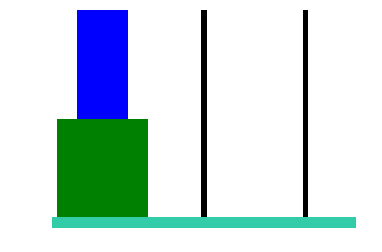

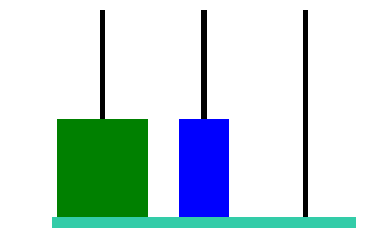

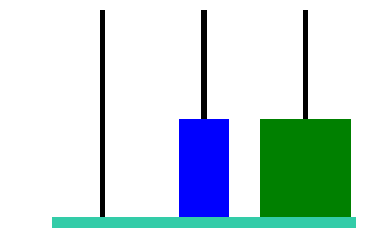

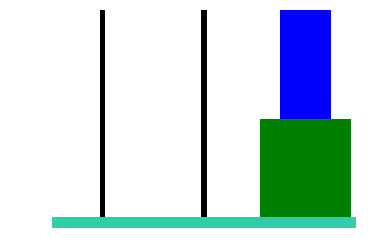

In [8]:
# example usage of print_game_sequence with a game of 2 disks played optimally
game = []
game.append([[2,1],[],[]])
game.append([[2],[1],[]])
game.append([[],[1],[2]])
game.append([[],[],[2,1]])
print_game_sequence(game)
del(game)

<a id="algorithms"></a>
Algorithms
-----------

Given a Markov decision process we are usually interested in finding a function called _policy_, commonly referred to as $\pi$, which is a function $\pi: S \to A$ that defines the strategy we will follow when inside the mdp. Usually our point is to maximize the quantity

$$E[R] = \sum_{t=0}^\infty \gamma^t r_t$$

which is the expected reward we get when in the mdp. From a rather intuitive point of view, the mdp can be thought of a game and the rewards can be thought of points. When we play, we want to get as many points as possible! For that, we must know what are the moves to make (the actions) at each point of the "game" (the states).

What the algorithms of RL give us is a way to find what the best policy is, so that we can use it in our environments. In this example of the Tower of Hanoi, the policy $\pi$ is a function that, given a board state, tells us what the best move to make is!

<a id="value_iteration"></a>
### Value iteration

[Value iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Value_iteration) is a great place to start learning about RL algorithms! To understand value iteration, think of this:

What if we tried to attribute a value to each state? For each state $s$, let us look for a value $V(s)$ that reflects how good it is for me to be in state $s$. If you had something like that, then we would know how to act! Whenever we have to take an action, just choose the action that will take us to the state with best value!

A good candidate for the value $V(s)$ of the state $s$ would be the expected reward we would get from $s$ onwards. If we are following the optimal policy $\pi^*$ and if we write $a = \pi^*(s)$ (i.e. if the action $a$ is the optimal action to take when in state $s$) then the following equality holds:

$$V(s) = \sum_{s' \in S} P_a(s,s')\left(R_a(s,s') + \gamma V(s')\right) $$

which is a recursive definition of $V$ and that is related to the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation), an equation that you will find frequently when learning about RL. Having found this equality, one could pretty much invent the algorithm all by itself! The algorithm has two steps:

 - Define initial values $V_0(s)$ for each state, representing your initial guesses of the values of each state
 
 - Repeatedly update the values of $V$ with the relation
 
 $$V_{n+1}(s) = \max_a \{ \sum_{s' \in S} P_a(s,s')\left(R_a(s,s') + \gamma V_n(s')\right) \}$$
 
Notice that, because we don't know what the optimal policy is, we can't set $a = \pi^*(s)$ and then update $V$ according to that action... Because of that, we have to estimate what the best action would be, and we do that by assuming the optimal action is the one that _maximizes_ the future expected reward.

Of course that just by this explanation we have no idea if this would work or not, but it can be shown that this iterative process converges, and thus it makes sense to use it.

### TL;DR

We define $V(s) = 0$ for every state in $S$ and then iteratively update the values, for each state re-assigning the value of $V(s)$ as

$$V(s) = \max_a \{ \sum_{s' \in S} P_a(s,s')\left(R_a(s,s') + \gamma V_n(s')\right) \}$$

until the values of $V$ don't change from one iteration to the next one. After that process has been completed, the optimal policy $\pi^*$ is

$$\pi^*(s) = arg\,max_a \{ \sum_{s' \in S} P_a(s,s')\left(R_a(s,s') + \gamma V_n(s')\right) \}$$

and now... the code!

Below you can find the part of the code that does the actual value iteration and updates the values of $V$ until the changes are bareably noticeable (that is, the changes are below a certain threshold).

We start by defining the number of disks and the discount factor $\gamma$. After that we define all the possible states and initialize $V$ at $0$, except for the value of the terminal state, which we initialize with a very high value. Later when we are updating the values of all the states, we skip that terminal state. If we didn't want to initialize the terminal state differently, then we would have to treat the terminal state differently in the value iteration (you will see what I mean when we get to the Q-learning algorithm).

The main loop is just the value iteration as I described earlier.

In [9]:
N = 5 # number of disks

gamma = 0.9

all_states = define_states(N)

# initialize V
V = {dictify(state): 0 for state in all_states[1:]}
V[FINAL_STATE] = 99999  # infinite value
max_change = 1  # error tolerance
i = 0
max_iters = pow(10, N)
while max_change > 0.001 and i < max_iters:
    max_change = 0
    # skip the terminal state, that one has infinite value
    for state in all_states[1:]:
        m = -10000
        for action in actions:
            go_to, reward = transition(state, action)
            temp = reward + gamma*V[dictify(go_to)]
            if temp > m:
                m = temp
        max_change = max(max_change, abs(m - V[dictify(state)]))
        V[dictify(state)] = m
    i += 1
if i == max_iters:
    print("NO CONVERGENCE GUARANTEED")

After the value iteration is completed, we can then extract the policy and apply it to our game!

Notice that my `create_policy` function returns a function, and uses a really nice trick called _memoization_ to spare us some work! We just compute the $\pi(s)$ values we end up needing, not all of them! For these values of $N$ this isn't really meaningful, but it is a good excuse to train a different technique.

In [14]:

def create_policy(V):
    """Given the final dict of state values, creates the policy"""
    known_values = dict()   # store already computed values
    def policy(state):
        # if we have computed this action, use it
        t = dictify(state)
        if t in known_values.keys():
            return known_values[t]
        else:   # we still need to find what is the action that maximizes
            best_action = None
            best_value = -1000000
            for action in actions:
                go_to, _ = transition(state, action)
                value = V[dictify(go_to)]
                if value > best_value:
                    best_value = value
                    best_action = action
            known_values[t] = best_action
            return best_action
    return policy

# solve the Tower of Hanoi
state = [[i for i in range(N, 0, -1)],[],[]]
pi = create_policy(V)
stop_at = pow(2, N+1)
iter = 0
game = [state]
while state != FINAL_STATE and iter < stop_at:
    print("{}: {}".format(iter, state))
    state, _ = transition(state, pi(state))
    game.append(state)
    iter += 1
game = game[:-1] # remove the terminal state that isn't printable by print_game_sequence

0: [[5, 4, 3, 2, 1], [], []]
1: [[5, 4, 3, 2], [1], []]
2: [[5, 4, 3], [1], [2]]
3: [[5, 4, 3], [], [2, 1]]
4: [[5, 4], [3], [2, 1]]
5: [[5, 4, 1], [3], [2]]
6: [[5, 4, 1], [3, 2], []]
7: [[5, 4], [3, 2, 1], []]
8: [[5], [3, 2, 1], [4]]
9: [[5], [3, 2], [4, 1]]
10: [[5, 2], [3], [4, 1]]
11: [[5, 2, 1], [3], [4]]
12: [[5, 2, 1], [], [4, 3]]
13: [[5, 2], [1], [4, 3]]
14: [[5], [1], [4, 3, 2]]
15: [[5], [], [4, 3, 2, 1]]
16: [[], [5], [4, 3, 2, 1]]
17: [[1], [5], [4, 3, 2]]
18: [[1], [5, 2], [4, 3]]
19: [[], [5, 2, 1], [4, 3]]
20: [[3], [5, 2, 1], [4]]
21: [[3], [5, 2], [4, 1]]
22: [[3, 2], [5], [4, 1]]
23: [[3, 2, 1], [5], [4]]
24: [[3, 2, 1], [5, 4], []]
25: [[3, 2], [5, 4, 1], []]
26: [[3], [5, 4, 1], [2]]
27: [[3], [5, 4], [2, 1]]
28: [[], [5, 4, 3], [2, 1]]
29: [[1], [5, 4, 3], [2]]
30: [[1], [5, 4, 3, 2], []]
31: [[], [5, 4, 3, 2, 1], []]


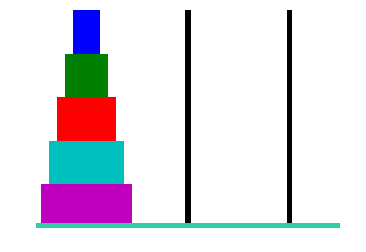

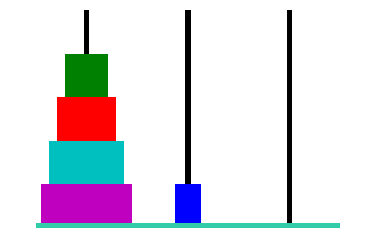

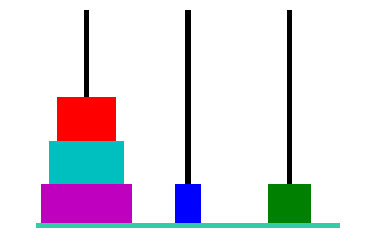

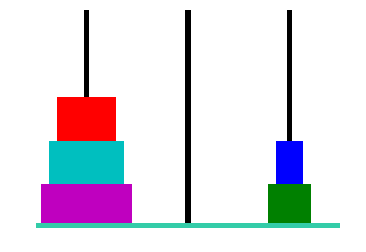

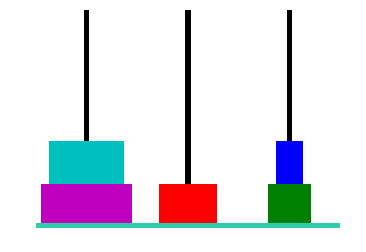

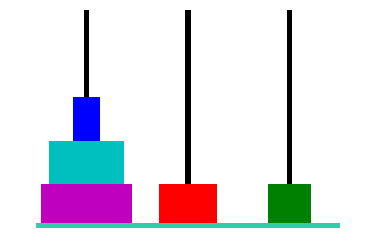

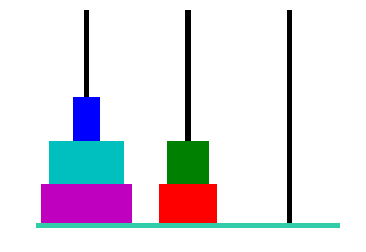

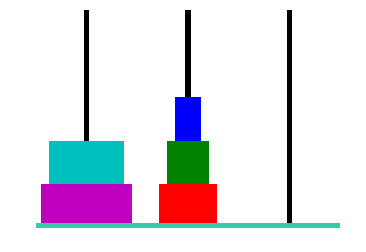

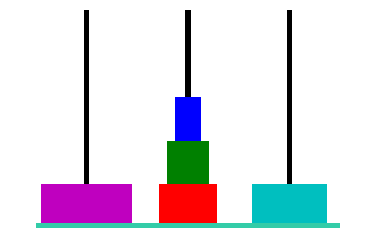

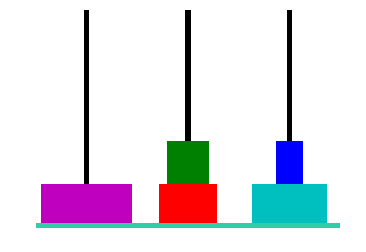

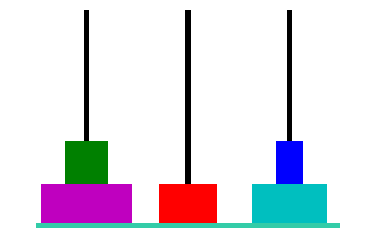

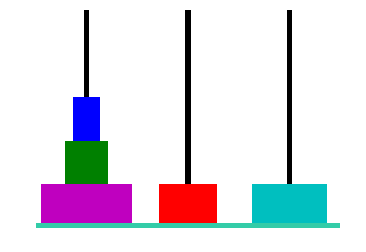

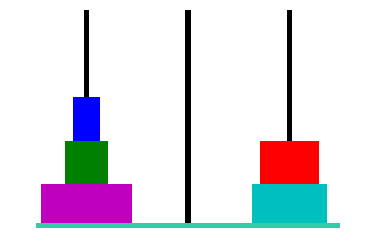

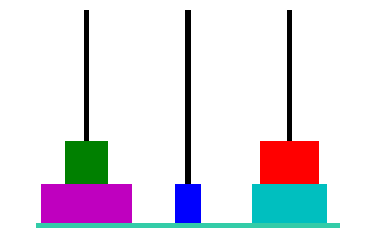

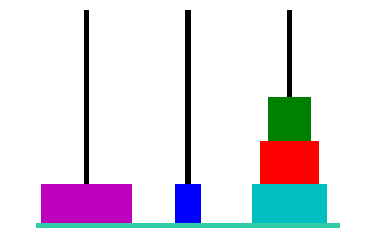

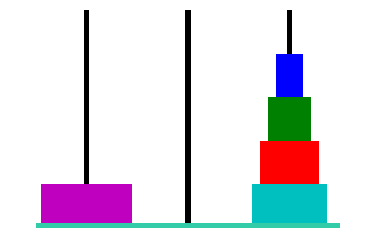

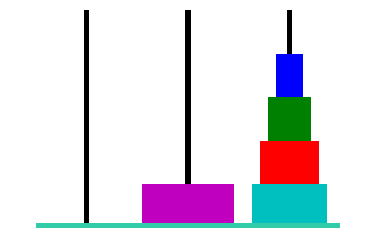

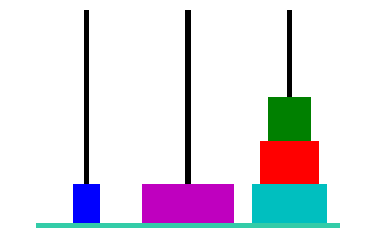

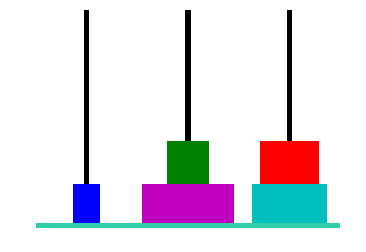

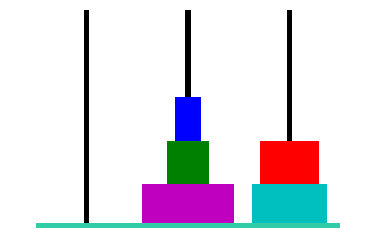

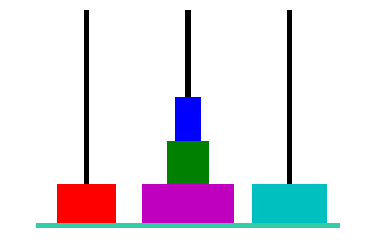

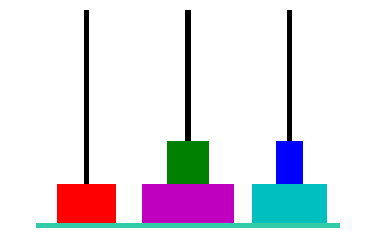

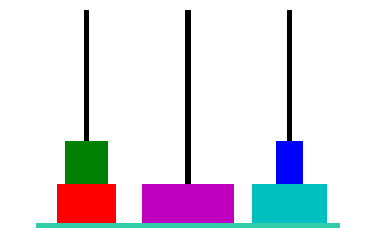

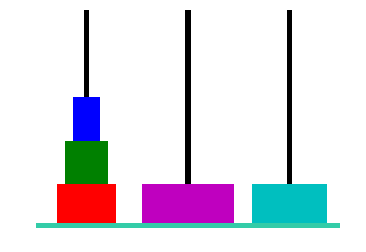

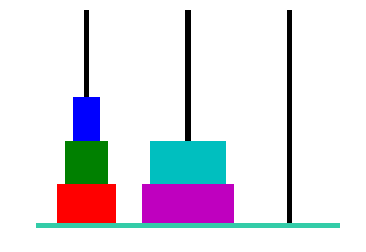

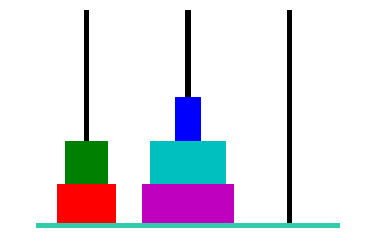

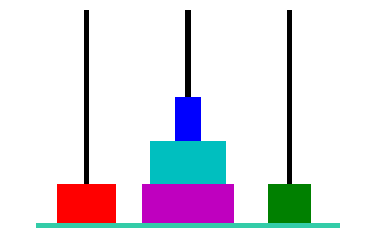

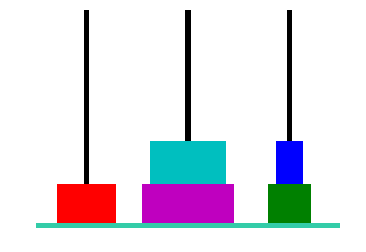

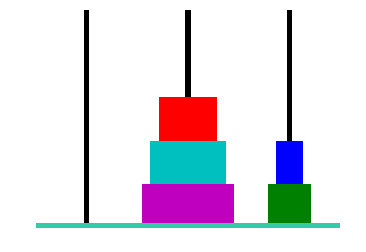

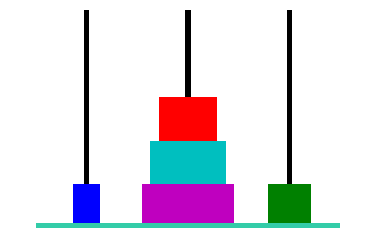

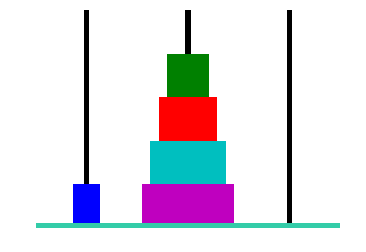

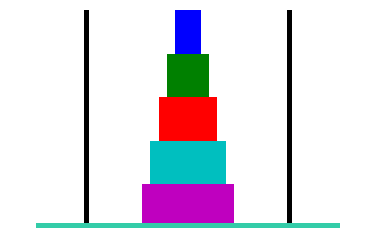

In [15]:
print_game_sequence(game)

### Side note on memoization

The technique of memoization can be used to speed up the computation of some functions (at the cost of some memory, of course). A classical example is that of the Fibonacci function! The $n$-th Fibonacci number is defined as

$$F_n = F_{n-1} + F_{n-2}$$

with $F_0 = F_1 = 1$. The expression above is trivially translated into code, giving the function `fibonacci` below:

In [17]:
def fibonacci(n):
    if n == 0 or n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)

In [25]:
%%time
fibonacci(33)

Wall time: 2.92 s


5702887

Notice that computing $F_{33}$ already takes close to $3$ seconds! But if we reimplement the recursive Fibonacci function with the memoization as below, we get really significant speed-ups!

(of course one can implement the Fibonacci function iteratively thus dealing with this problem _without_ resorting to memoization)

In [57]:
del fib # delete the function so that the stored values don't linger around

def memoization_wrapper(f):
    d = dict()
    def function(inp):
        if inp not in d.keys():
            d[inp] = f(inp)
        return d[inp]
    return function

@memoization_wrapper
def fib(n):
    if n == 0 or n == 1:
        return 1
    else:
        return fib(n-1) + fib(n-2)
    
%time fib(480)

Wall time: 0 ns


14913169640232740127827512057302148063648650711209401966150219926546779697987984279570098768737999681

<a id="policy_iteration"></a>
### Policy iteration

<a id="q_learning"></a>
### Q-learning

<a id="doubleq_learning"></a>
### Double Q-learning